<a href="https://colab.research.google.com/github/chidinma-godwin/course-recommendation-nlp/blob/main/course_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 37.7 MB/s eta 0:00:00


In [ ]:
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
gcsfs 2024.6.1 requires fsspec==2024.6.1, but you have fsspec 2024.5.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 

In [ ]:
!pip install -q adjustText

In [ ]:
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Suppress the TqdmExperimentalWarning
from tqdm import TqdmExperimentalWarning
import warnings
warnings.filterwarnings('ignore', category=TqdmExperimentalWarning)

In [ ]:
import re
import string
import random
import json
import os
import pickle
import time
from tqdm.auto import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import spacy

from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import tensorflow as tf
import keras
from tensorflow.keras.layers import TextVectorization, Input, Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import keras_tuner as kt
import torch

from sentence_transformers import SentenceTransformer, CrossEncoder
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TextStreamer

In [ ]:
session_time = int(time.time())

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
!nvidia-smi

Tue Jul 16 21:08:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Data Exploration

In [ ]:
base_dir = "/content/drive/MyDrive/project"

df = pd.read_csv(f"{base_dir}/courseslist.csv")
df.head()

,additional_course_detail,course_avg_rating,course_certificate,course_institution,course_is_classroom,course_is_university,course_level,course_link,course_name,course_num_rating,course_provider,course_subject,course_type,description,duration,is_all_time_best,pricing,start_date,teacher
0,Welcome to the world of programming! Learn the...,4.84906,True,NaN,False,False,beginner,https://www.classcentral.com/course/intro-to-p...,Introduction to Programming,53,Udacity,Programming,microcredential,Master coding basics with this 17-week Udacity...,4 months 3 weeks,False,Paid Course,On-Demand,"Karl Krueger, Kelly Howard, Julia Van Cleve, J..."
1,",This course bridges the gap between introduct...",3.66667,True,Harvard University,False,True,intermediate,https://www.classcentral.com/course/python-har...,Using Python for Research,12,edX,Programming,course,Master coding basics with this 17-week Udacity...,4 months 3 weeks,False,Paid Course,On-Demand,Jukka-Pekka JP Onnela
2,This course takes Java beginners to the next l...,4.45000,True,University of Alberta,False,True,intermediate,https://www.classcentral.com/course/object-ori...,Object-Oriented Design,40,Coursera,Programming,course,Master coding basics with this 17-week Udacity...,4 months 3 weeks,False,Paid Course,On-Demand,Kenny Wong
3,This Specialization builds on the success of t...,4.88462,True,University of Michigan,False,True,beginner,https://www.classcentral.com/course/python-186...,Python for Everybody,416,Coursera,Python,microcredential,Master coding basics with this 17-week Udacity...,4 months 3 weeks,False,Paid Course,On-Demand,Charles Russell Severance
4,This course will introduce the core data struc...,4.89328,True,University of Michigan,False,True,beginner,https://www.classcentral.com/course/python-dat...,Python Data Structures,16426,Coursera,Python,course,Master coding basics with this 17-week Udacity...,4 months 3 weeks,False,Paid Course,On-Demand,Charles Severance


In [ ]:
df.duplicated().sum()

0

In [ ]:
df = df.replace(np.nan, None)
df.isna().sum()

additional_course_detail        0
course_avg_rating               0
course_certificate              0
course_institution          20813
course_is_classroom             0
course_is_university            0
course_level                16715
course_link                     0
course_name                     0
course_num_rating               0
course_provider                 0
course_subject                  0
course_type                     0
description                     0
duration                       65
is_all_time_best                0
pricing                         0
start_date                      0
teacher                     10840
dtype: int64

In [ ]:
df['course_subject'].value_counts().reset_index().set_index('course_subject')

,count
course_subject,
Python,1332
Microsoft Azure,1198
Google Cloud Platform (GCP),1111
Uncategorized,1008
Javascript,812
...,...
Culture,1
IT Compliance,1
LDAP,1


In [ ]:
df['course_level'].value_counts(dropna=False).reset_index().set_index('course_level')

,count
course_level,
None,16715
beginner,11844
intermediate,5625
advanced,979


In [ ]:
df['pricing'].value_counts().reset_index()

,pricing,count
0,Free Online Course,11498
1,Free Trial Available,9615
2,Paid Course,9502
3,Free Online Course (Audit),2987
4,Conference Talk,747
5,Free Certificate,525
6,$14.00,28
7,"$7,500.00",15
8,$297.00,15
9,$34.00,15


In [ ]:
df['course_is_university'].value_counts().reset_index().set_index('course_is_university')

,count
course_is_university,
False,32392
True,2771


In [ ]:
df['course_provider'].value_counts().reset_index().set_index('course_provider')

,count
course_provider,
YouTube,8452
Udemy,8248
Pluralsight,4389
Coursera,3711
LinkedIn Learning,3620
...,...
Marginal Revolution University,1
OpenLearning,1
Stepik,1


In [ ]:
df[df['course_subject'] == 'Uncategorized'].head()

,additional_course_detail,course_avg_rating,course_certificate,course_institution,course_is_classroom,course_is_university,course_level,course_link,course_name,course_num_rating,course_provider,course_subject,course_type,description,duration,is_all_time_best,pricing,start_date,teacher
478,"Introduction,Project Overview,Case Scenario,Al...",0.0,False,Stanford University,True,True,None,https://www.classcentral.com/classroom/youtube...,Picking on the Same Person - Does Algorithmic ...,0,YouTube,Uncategorized,course,Stanford University offers a brief seminar exp...,35 minutes,False,Free Online Course,On-Demand,None
479,"Introduction,Linear approach,landscape changes...",0.0,False,Stanford University,True,True,None,https://www.classcentral.com/classroom/youtube...,"AI, Archaeology, and Archives - How Data Scien...",0,YouTube,Uncategorized,course,Stanford University offers a brief seminar exp...,35 minutes,False,Free Online Course,On-Demand,None
480,"Introduction,Our Story Begins,The History of t...",0.0,False,Stanford University,True,True,None,https://www.classcentral.com/classroom/youtube...,"Voices in the Code - A Story About People, The...",0,YouTube,Uncategorized,course,Stanford University offers a brief seminar exp...,35 minutes,False,Free Online Course,On-Demand,None
497,Stanford Seminar: PyWren - Pushing Microservic...,0.0,False,Stanford University,True,True,None,https://www.classcentral.com/classroom/youtube...,Stanford Seminar - PyWren - Pushing Microservi...,0,YouTube,Uncategorized,course,Stanford University offers a brief seminar on ...,45 minutes,False,Free Online Course,On-Demand,None
498,"Stanford Seminar: Data For The People, Andreas...",0.0,False,Stanford University,True,True,None,https://www.classcentral.com/classroom/youtube...,Data for the People - Andreas Weigend of Socia...,0,YouTube,Uncategorized,course,Stanford University offers a brief seminar on ...,45 minutes,False,Free Online Course,On-Demand,None


## Data Preprocessing

In [ ]:
# Function to create a meaningful combined course details
def create_combined_details(row):
    teacher_and_duration = ""
    if row['teacher'] and row['duration']:
        teacher_and_duration = f"The course was taught by {row['teacher']} and has a duration of {row['duration']}"
    elif row['teacher']:
        teacher_and_duration = f"The course was taught by {row['teacher']}"
    elif row['duration']:
        teacher_and_duration = f"The course has a duration of {row['duration']}"

    certificate = " You can get a certificate after completing this course" if row['course_certificate'] else ""

    course_institution = f" by {row['course_institution']}" if row['course_institution'] else ""

    course_level = f" and is classified as {row['course_level']} level" if row['course_level'] else ""

    combined_details = (
        f"""{row['course_name']}: This {re.sub(r' Course', '', row['pricing'])} course was rated by \
{row['course_num_rating']} people with an average rating of {round(row['course_avg_rating'], 1)}. {teacher_and_duration}. \
This {row['course_subject']} course is offered on {row['course_provider']}{course_institution}{course_level}.{certificate}. {row['additional_course_detail']}. {row['description']}"""
    )
    return combined_details

In [ ]:
# Apply the function to each row to create the combined text
df["combined_details"] = df.apply(create_combined_details, axis=1)
df["combined_details"][0]

'Introduction to Programming: This Paid course was rated by 53 people with an average rating of 4.8. The course was taught by Karl Krueger, Kelly Howard, Julia Van Cleve, James Parkes, Richard Kalehoff, Greg C., Yodit F., Matthew R., John M., Vincenzo A. and James L. and has a duration of 4 months 3 weeks. This Programming course is offered on Udacity and is classified as beginner level. You can get a certificate after completing this course. Welcome to the world of programming! Learn the skills that all programmers use, whether they build apps, web pages, or analyze data.,,. Master coding basics with this 17-week Udacity course. Learn HTML, CSS, Python, and JavaScript, with no prior programming skills required. Ideal for beginners eyeing careers in tech.'

In [ ]:
print("Min: ", min(df["combined_details"].str.split().apply(len)))
print("Max: ", max(df["combined_details"].str.split().apply(len)))

Min:  50
Max:  5448


In [ ]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Initialize stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
nlp = spacy.load('en_core_web_sm')

infixes = list(nlp.Defaults.infixes)
infixes = [pattern for pattern in infixes if not ('-' in pattern or '_' in pattern or '/' in pattern)]
infixes_regex = spacy.util.compile_infix_regex(infixes)
nlp.tokenizer.infix_finditer = infixes_regex.finditer

In [ ]:
def preprocess_texts(texts):
    preprocessed_texts = []

    for text in texts:
        text = text.lower()
        text = re.sub(r'(?<=\d)[.](?=\d)', '√√√DOT√√√', text)  # Temporarily replace "." between numbers
        text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)  # Remove all punctuations
        text = re.sub(r'√√√DOT√√√', '.', text)  # Restore the preserved "."
        preprocessed_texts.append(text)

    lemmatized_texts = []

    for doc in nlp.pipe(preprocessed_texts, disable=["parser", "ner", "textcat"]):
        words = [token.lemma_ for token in doc if token.text not in stop_words]
        lemmatized_texts.append(' '.join(words))

    return lemmatized_texts

In [ ]:
df['preprocessed_details'] = preprocess_texts(df['combined_details'])
df['preprocessed_details'][0]

'introduction program pay course rate 53 people average rating 4.8 course teach karl krueger kelly howard julia van cleve james parkes richard kalehoff greg c yodit f matthew r john vincenzo james l duration 4 month 3 week programming course offer udacity classify beginner level get certificate complete course welcome world programming learn skill programmer use whether build app web page analyze data master code basic 17week udacity course learn html css python javascript prior programming skill require ideal beginner eye career tech'

In [ ]:
print("Min: ", min(df["preprocessed_details"].str.split().apply(len)))
print("Max: ", max(df["preprocessed_details"].str.split().apply(len)))

Min:  30
Max:  2841


## Data Visualization

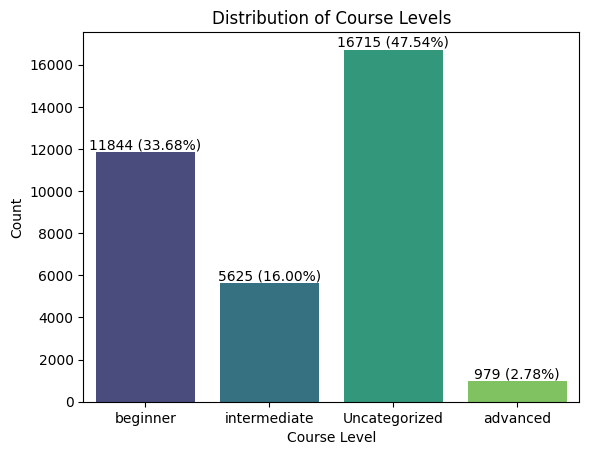

In [ ]:
filled_df = df['course_level'].fillna('Uncategorized', inplace=False)
ax = sns.countplot(x=filled_df, data=df, palette='viridis', hue=filled_df)
ax.set_title('Distribution of Course Levels')
ax.set_xlabel('Course Level')
ax.set_ylabel('Count')

# Add text on the bars
for rect in ax.patches:
    height = round(rect.get_height())
    percentage = (height / len(filled_df)) * 100
    ax.text(x=rect.get_x() + rect.get_width() / 2, y=height, s=f'{height} ({percentage:.2f}%)', ha='center', va='bottom')

plt.show()

In [ ]:
has_rating = df['course_num_rating'] == 0
has_rating.sum()

32934

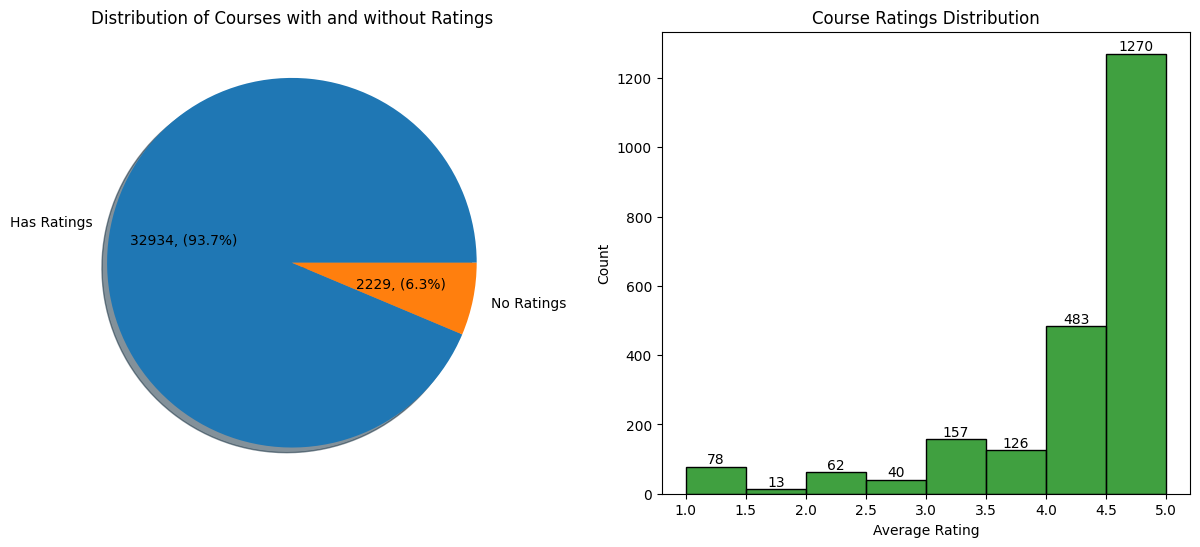

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sizes = [(df['course_num_rating'] == 0).sum(), (df['course_num_rating'] != 0).sum()]
labels = ['Has Ratings', 'No Ratings']
ax[0].pie(sizes, labels=labels, shadow=True, autopct=lambda pct:f'{(pct * sum(sizes) / 100):.0f}, ({pct:.1f}%)')
ax[0].set_title('Distribution of Courses with and without Ratings')

sns.histplot(df.loc[df['course_num_rating'] != 0, 'course_avg_rating'], bins=8, color='green', ax=ax[1])
ax[1].set_title('Course Ratings Distribution')
ax[1].set_xlabel('Average Rating')
ax[1].set_ylabel('Count')

# Add text on the bars
for rect in ax[1].patches:
    height = rect.get_height()
    ax[1].text(x=rect.get_x() + rect.get_width() / 2, y=height, s=height, ha='center', va='bottom')

plt.show()

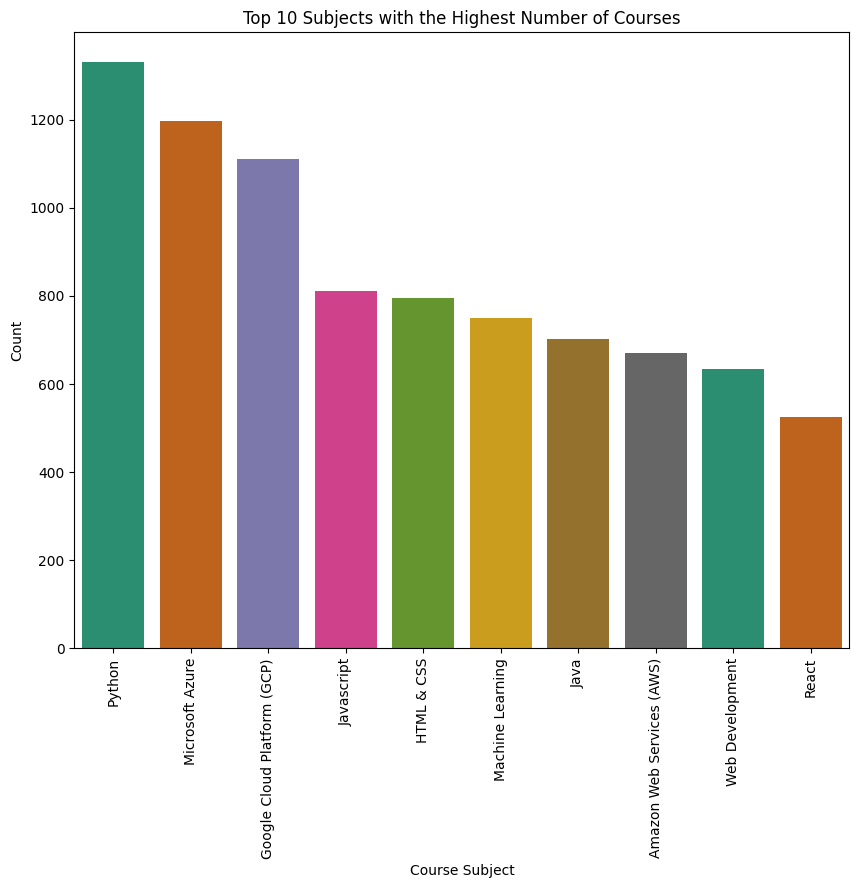

In [ ]:
top_subjects = df[df['course_subject'] != 'Uncategorized']['course_subject'].value_counts().reset_index()[:10]

fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(x='course_subject', y='count', data=top_subjects, palette='Dark2', hue='course_subject', ax=ax)
ax.set_title('Top 10 Subjects with the Highest Number of Courses')
ax.set_xlabel('Course Subject')
ax.set_ylabel('Count')

plt.xticks(rotation=90)
plt.show()

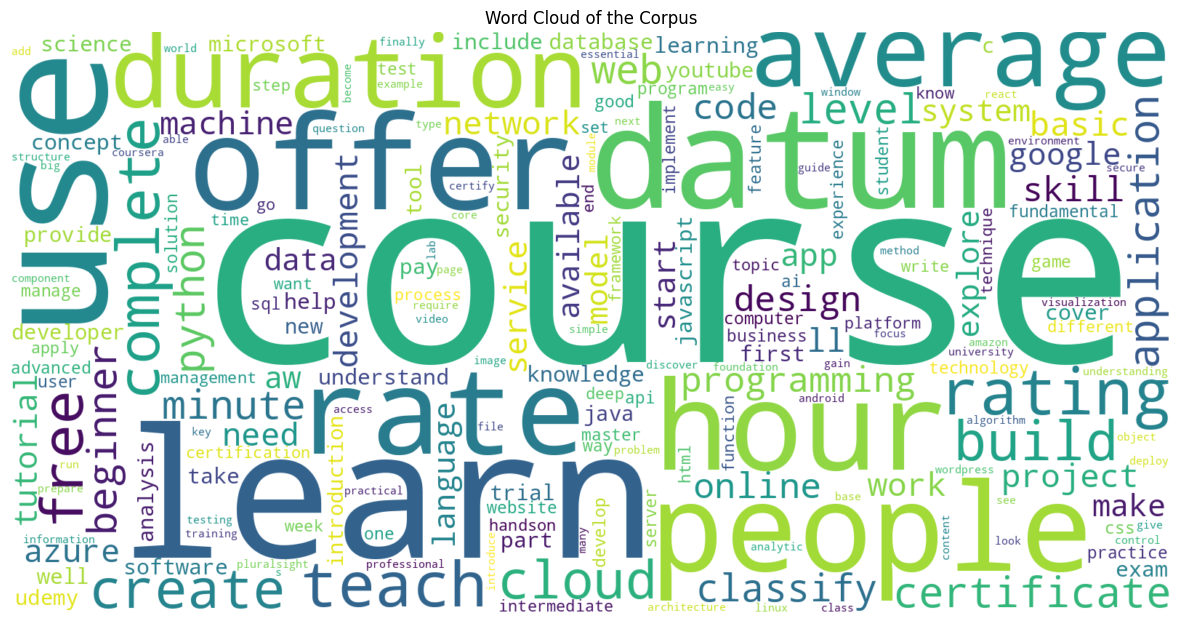

In [ ]:
wordcloud = WordCloud(width=1600, height=800, background_color='white', min_font_size=14,
                      collocations=False, max_words=200).generate(' '.join(df['preprocessed_details']))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of the Corpus')
plt.show()

## TF-IDF and Cosine Similarity

In [ ]:
# Example user query
user_query = "I want advanced course on python covering OOP and data structures with an average rating above 4.0"
processed_user_query = preprocess_texts([user_query])[0]
processed_user_query

'want advanced course python cover oop datum structure average rating 4.0'

In [ ]:
def recommend_courses_cosine(user_query_embedding, course_embeddings, data, return_score=True, top_n=4):
    # Compute cosine similarity between user query and courses
    cosine_sim = cosine_similarity(user_query_embedding, course_embeddings).flatten()
    if return_score:
        data['cosine_sim'] = cosine_sim
    # Get the top N similar courses
    top_indices = np.argsort(-cosine_sim)[:top_n]
    recommended_courses = data.iloc[top_indices]

    return recommended_courses

In [ ]:
vectorizer = TfidfVectorizer()

# Vectorize the text data using TF-IDF
tfidf_matrix = vectorizer.fit_transform(df['preprocessed_details'])
user_tfidf = vectorizer.transform([processed_user_query])

# Get recommendations
cosine_recommendations = recommend_courses_cosine(user_tfidf, tfidf_matrix, df)
print("Cosine Similarity Recommendations:")
cosine_recommendations[['course_name', 'course_avg_rating', 'course_level', 'cosine_sim']]

Cosine Similarity Recommendations:


,course_name,course_avg_rating,course_level,cosine_sim
34964,Learn Kotlin Programming – Full Course for Beg...,0.0,None,0.492158
860,Python OOP : Four Pillars of OOP in Python 3 f...,0.0,beginner,0.477251
6556,"Data Structures and OOP with C++ : CS104, CS10...",0.0,beginner,0.452569
2130,OOP in Python 3 for Machine Learning Beginners...,0.0,beginner,0.452005


In [ ]:
X_tfidf = tfidf_matrix.toarray()

# Step 2: Apply PCA for dimensionality reduction
pca = PCA(n_components=50)  # Adjust number of components as needed
X_pca = pca.fit_transform(X_tfidf)

# Step 3: Apply t-SNE for visualization (2D)
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# Step 4: Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], marker='o', s=30)  # Adjust marker and size as needed

# Annotate points with document labels
for i, label in enumerate(df['preprocessed_details']):
    plt.annotate(label[:20], (X_tsne[i, 0], X_tsne[i, 1]), fontsize=10, ha='center')

plt.title('t-SNE Visualization of TF-IDF Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()

## Word2Vec and Cosine Similarity

In [ ]:
def get_average_word2vec(text, model):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

word2vec_model = Word2Vec(sentences=list(df["preprocessed_details"].str.split()), vector_size=300, window=5, min_count=1, workers=4, epochs=20)

course_embedding = df['preprocessed_details'].apply(lambda x: get_average_word2vec(x, word2vec_model))
user_query_embedding = get_average_word2vec(processed_user_query, word2vec_model)

In [ ]:
def visualize_embeddings(embeddings, labels, num_words=250):
    X = embeddings[:num_words]

    pca = PCA(n_components=50, random_state=42)
    X_pca = pca.fit_transform(X)

    tsne = TSNE(n_components=2, random_state=42)
    vectors_tsne = tsne.fit_transform(X_pca)

    plt.figure(figsize=(20, 12))
    plt.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1], marker='')

    texts = []
    for i, label in enumerate(labels[:num_words]):
        texts.append(plt.text(vectors_tsne[i, 0], vectors_tsne[i, 1], label, fontsize=12, ha='center', va='center', alpha=0.7))

    adjust_text(texts)

    plt.title('t-SNE Visualization of Word Embeddings')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(False)
    plt.show()

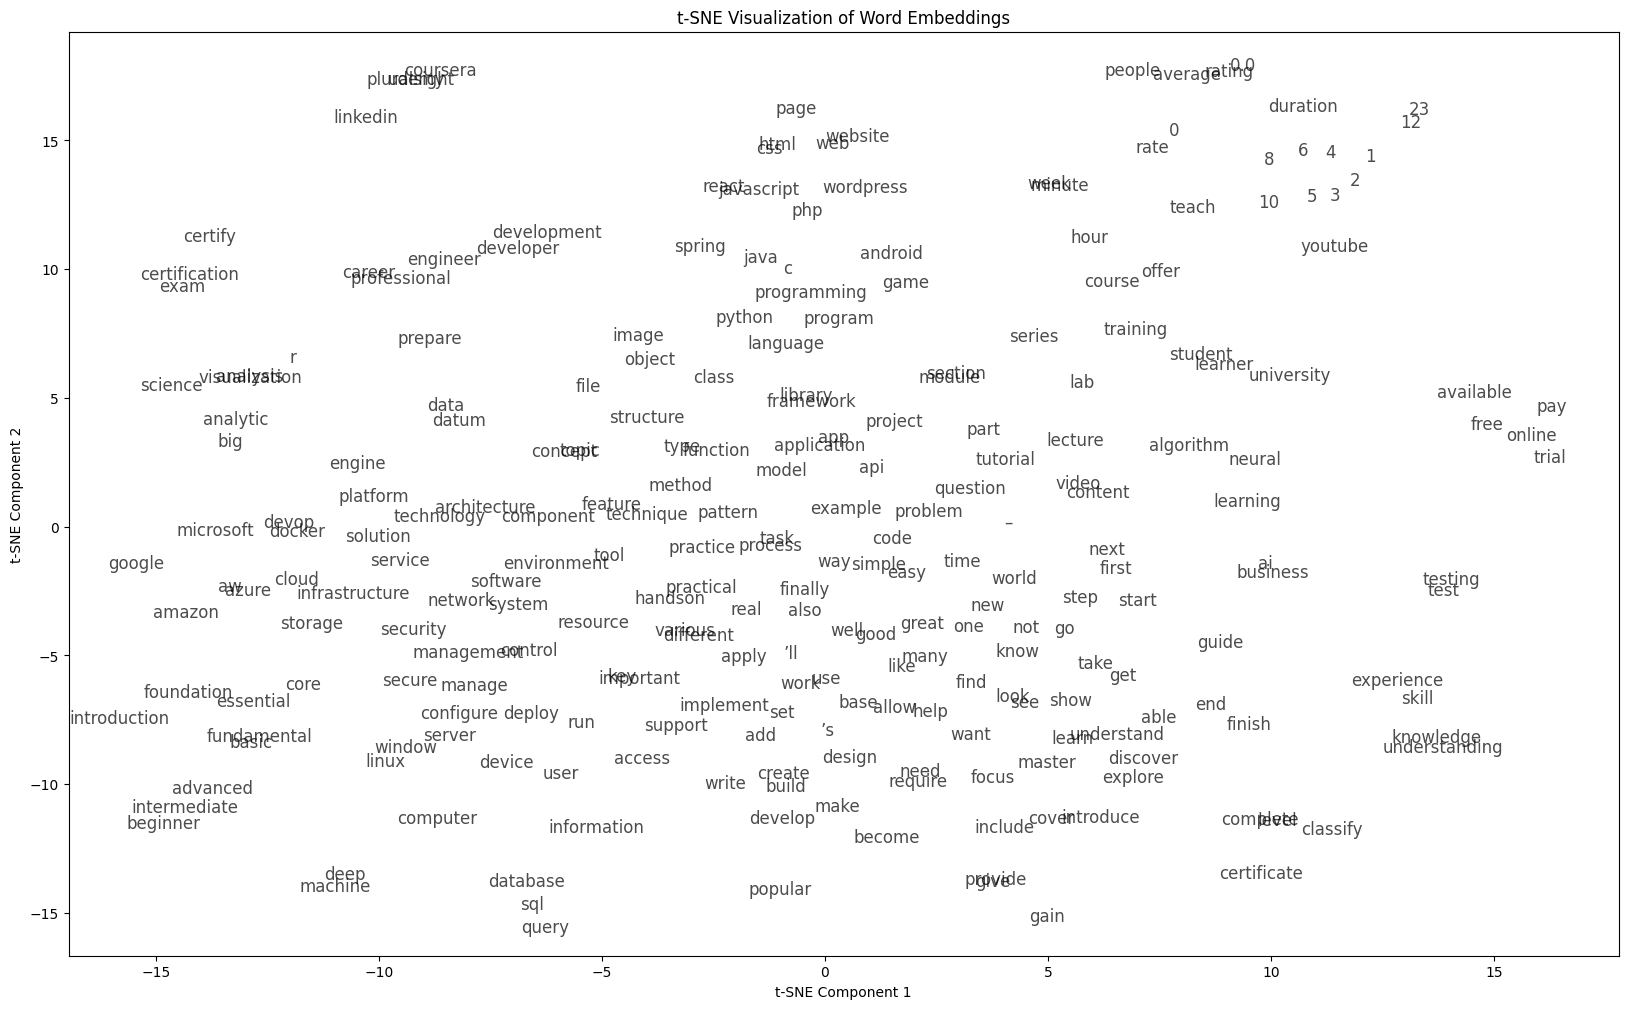

In [ ]:
keyedVectors = word2vec_model.wv

visualize_embeddings(embeddings=keyedVectors[keyedVectors.key_to_index], labels=keyedVectors.index_to_key)

In [ ]:
cosine_recommendations = recommend_courses_cosine([user_query_embedding], course_embedding.tolist(), df)
print("Cosine Similarity Recommendations:")
cosine_recommendations[['course_name', 'course_avg_rating', 'course_level', 'cosine_sim']]

Cosine Similarity Recommendations:


,course_name,course_avg_rating,course_level,cosine_sim
21476,Lets Learn Python,0.0,beginner,0.833944
25262,Python for Students,0.0,None,0.831998
10912,Python for beginners,0.0,beginner,0.825207
1759,Learn NumPy Fundamentals (Python Library for D...,0.0,beginner,0.820314


In [ ]:
sims = word2vec_model.wv.most_similar('python', topn=10)  # get other similar words
for item in sims:
  print (item)

('panda', 0.5097888112068176)
('r', 0.4646201431751251)
('numpy', 0.46133920550346375)
('programming', 0.4597439169883728)
('matplotlib', 0.4538889229297638)
('java', 0.4536266624927521)
('pythonpython', 0.45036977529525757)
('c', 0.40811416506767273)
('rust', 0.400039941072464)
('javascript', 0.39853188395500183)


## Doc2Vec and Cosine Similarity

In [ ]:
# Prepare data for Doc2Vec
documents = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(df['preprocessed_details'])]

# Train Doc2Vec model
doc2vec_model = Doc2Vec(documents, vector_size=300, window=5, min_count=1, workers=4, epochs=20)

# Sample user query
user_query_embedding = doc2vec_model.infer_vector(processed_user_query.split())

# Get course embeddings as a list of numpy arrays
course_embeddings = np.array(df['preprocessed_details'].apply(lambda x: doc2vec_model.infer_vector(x.split())).tolist())

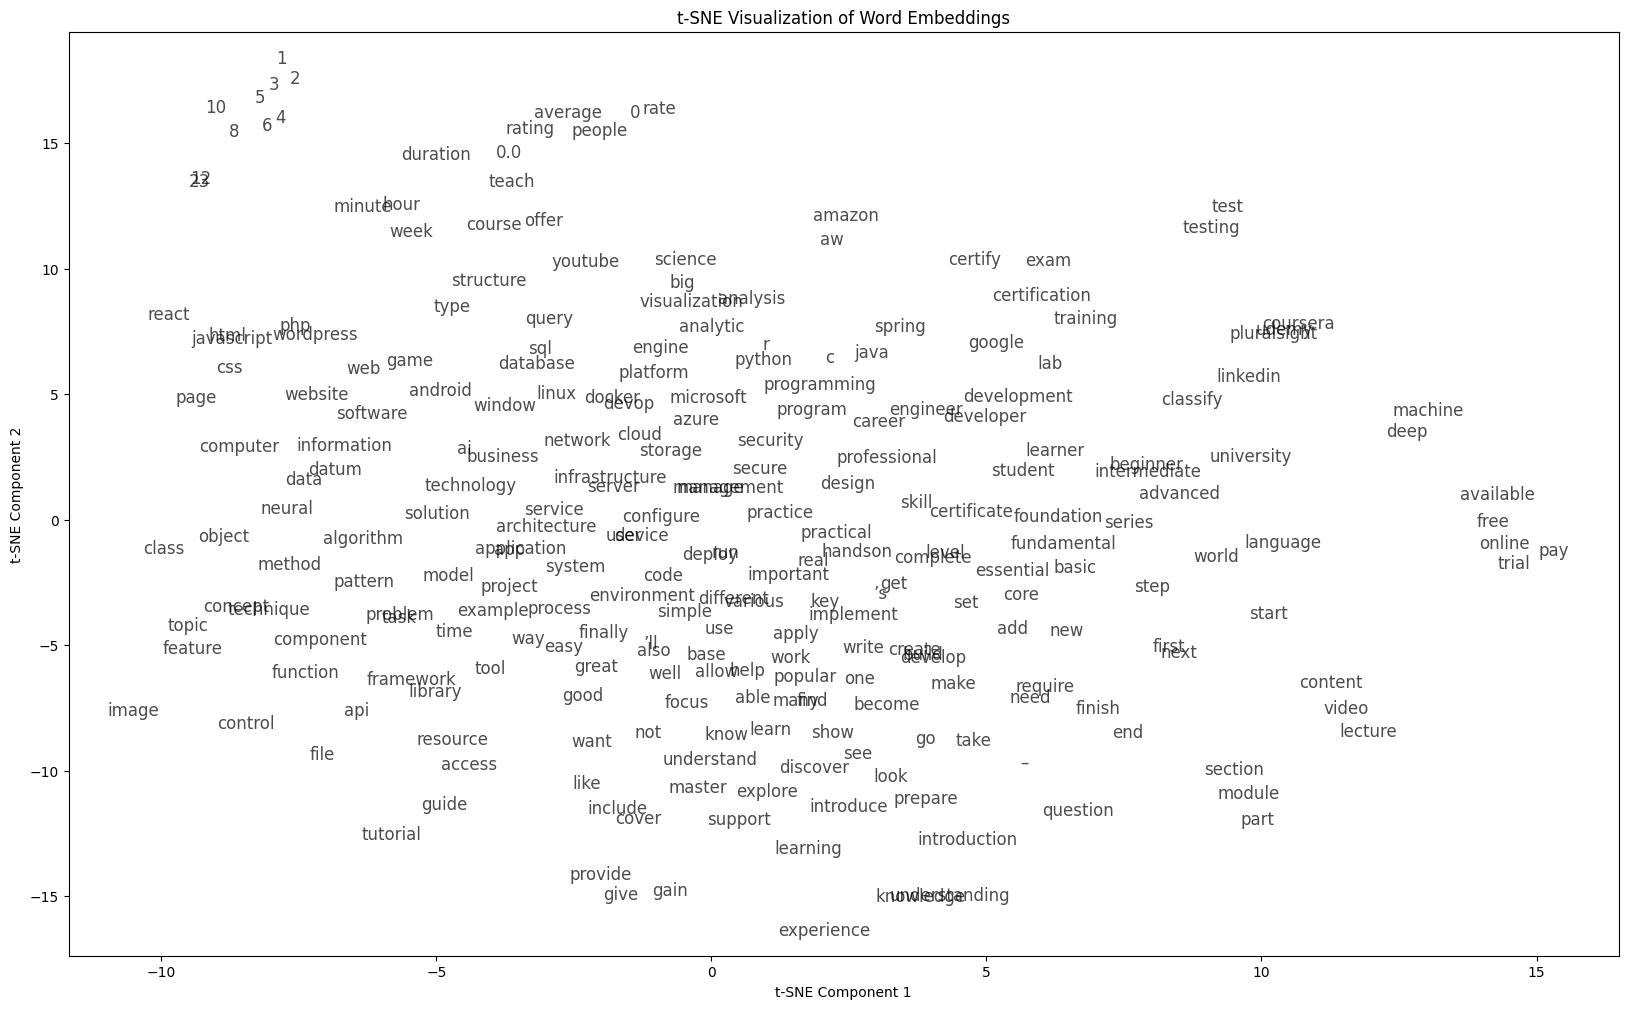

In [ ]:
keyedVectors = doc2vec_model.wv
visualize_embeddings(embeddings=keyedVectors[keyedVectors.key_to_index], labels=keyedVectors.index_to_key)

In [ ]:
recommended_courses = recommend_courses_cosine([user_query_embedding], course_embeddings, df)
print("Cosine Similarity Recommendations:")
recommended_courses[['course_name', 'course_avg_rating', 'course_level', 'cosine_sim']]

Cosine Similarity Recommendations:


,course_name,course_avg_rating,course_level,cosine_sim
4183,Data Structures in C++,0.0,intermediate,0.417901
13937,Flutter 1.2 with Firebase&Stripe Build shop ap...,0.0,intermediate,0.353916
13610,Python - A Beginners guide towards Python Prog...,0.0,beginner,0.335586
6915,Free CCNA 200-301 Course: Network Fundamentals,0.0,beginner,0.321330


In [ ]:
sims = doc2vec_model.wv.most_similar('python', topn=10)  # get other similar words
for item in sims:
  print (item)

('panda', 0.5105562210083008)
('programming', 0.4710765779018402)
('matplotlib', 0.4679563045501709)
('numpy', 0.4544864594936371)
('r', 0.44332465529441833)
('rust', 0.4213220179080963)
('pythonpython', 0.41323840618133545)
('java', 0.4115460216999054)
('jupyter', 0.4087800681591034)
('course', 0.4066459834575653)


## Sentence Transformer and Cosine Similarity

In [ ]:
sentence_transformer_model = SentenceTransformer('multi-qa-mpnet-base-cos-v1', device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.25k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def chunk_sequence(data, chunk_size=300, overlap=20):
    segmented_data = []

    for idx, sequence in enumerate(data):
        chunks = []
        words = sequence.split()
        for i in range(0, len(words), chunk_size - overlap):
            chunk = ' '.join(words[i:i + chunk_size])
            chunks.append(chunk)
        segmented_data.extend((idx, chunk) for chunk in chunks)

    return segmented_data

def get_aggregated_embeddings(data):
    segmented_data = chunk_sequence(data)
    segmented_texts = [chunk for idx, chunk in segmented_data]
    embeddings = sentence_transformer_model.encode(segmented_texts)

    original_sequence_embeddings = []
    for idx, sequence in tqdm(enumerate(data)):
        sequence_chunks = [embeddings[i] for i, (orig_idx, _) in enumerate(segmented_data) if orig_idx == idx]
        aggregated_embedding = np.mean(sequence_chunks, axis=0)
        original_sequence_embeddings.append(aggregated_embedding)

    return original_sequence_embeddings

In [ ]:
course_embedding = get_aggregated_embeddings(df['combined_details'].values)
user_input_encoding = get_aggregated_embeddings([user_query])

In [ ]:
# np.save(f"{base_dir}/course_sentence_embeddings.npy", course_embedding)
# course_embedding = np.load(f'{base_dir}/course_sentence_embeddings.npy')

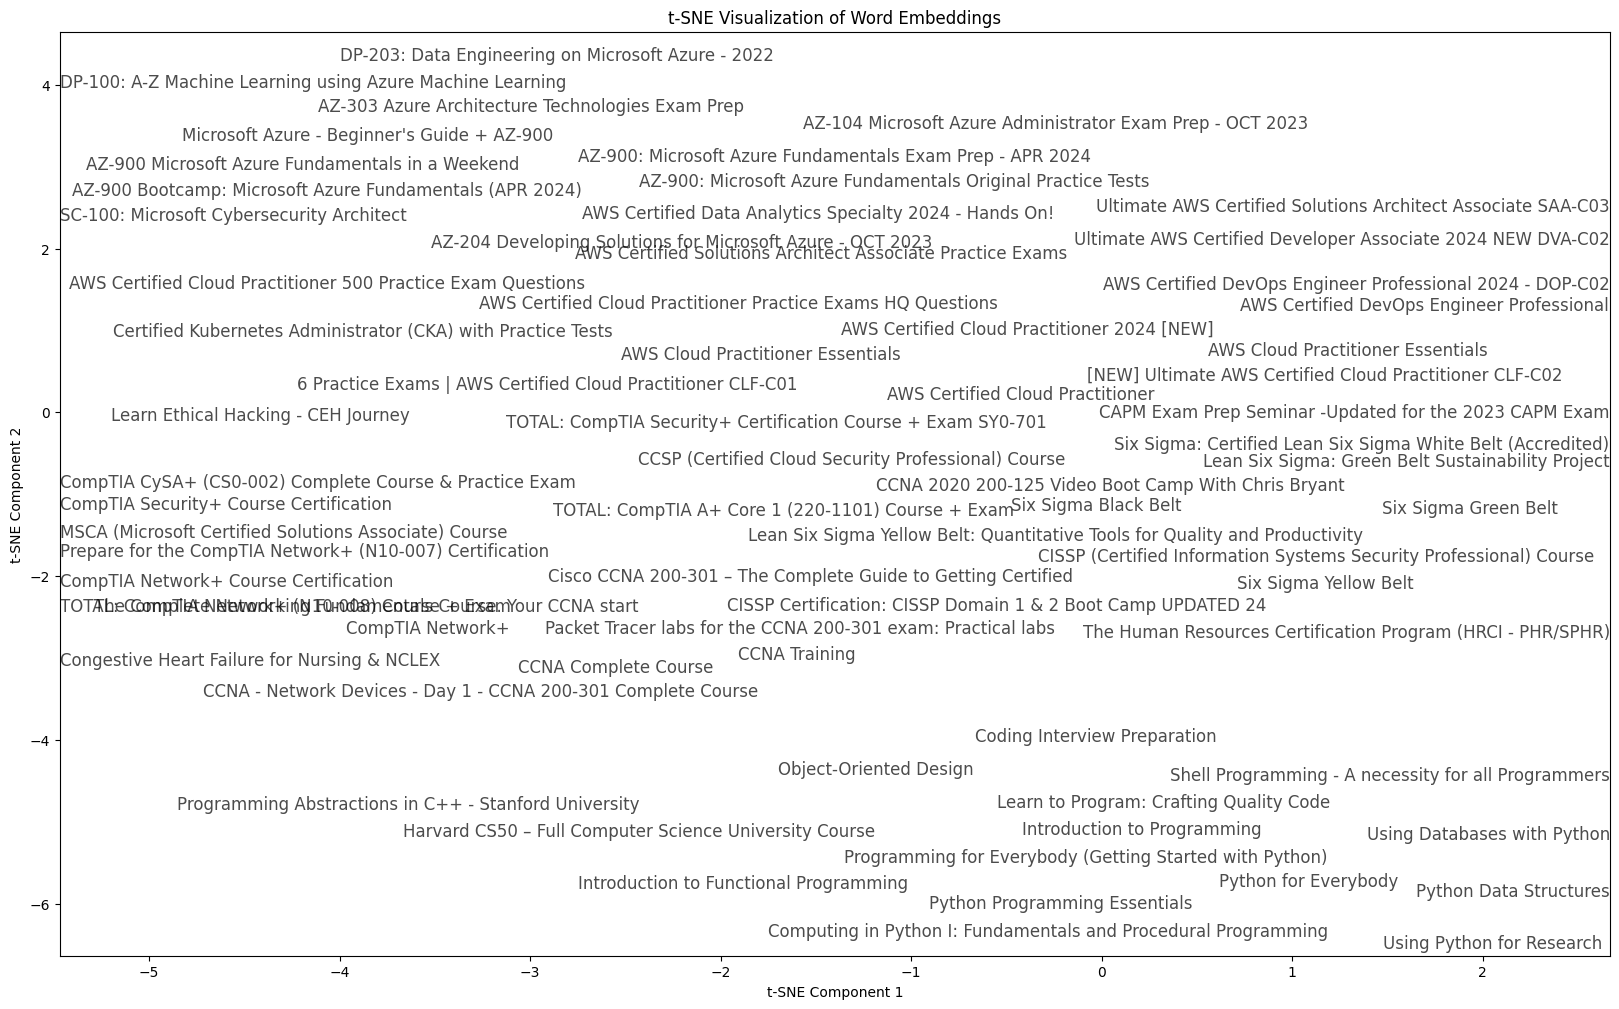

In [ ]:
visualize_embeddings(embeddings=course_embedding, labels=df['course_name'].values, num_words=70)

In [ ]:
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', default_activation_function=torch.nn.Sigmoid())

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
def rank_recommend_courses(user_query_embedding, course_embeddings, data, rank_courses=True, return_score=True, top_n=5):
    data = data.copy()
    cosine_sim = cosine_similarity(user_query_embedding, course_embeddings).flatten()
    if return_score:
        data['cosine_sim'] = cosine_sim
    top_indices = np.argsort(-cosine_sim)[:20]
    recommended_courses = data.iloc[top_indices]

    if not rank_courses:
        return recommended_courses

    top_n_courses = recommended_courses['combined_details'].values
    pairs = [(user_query, course) for course in top_n_courses]
    cross_scores = cross_encoder.predict(pairs)
    if return_score:
        recommended_courses = recommended_courses.copy()
        recommended_courses.loc[:, 'rank_score'] = cross_scores
    rank = np.argsort(-cross_scores)[:top_n]
    ranked_courses = recommended_courses.iloc[rank]

    return ranked_courses

In [ ]:
cosine_recommendations = rank_recommend_courses(user_input_encoding, course_embedding, df)
print("Cosine Similarity Recommendations:")
cosine_recommendations[['course_name', 'course_avg_rating', 'course_level', 'cosine_sim', 'rank_score']]

Cosine Similarity Recommendations:


,course_name,course_avg_rating,course_level,cosine_sim,rank_score
2130,OOP in Python 3 for Machine Learning Beginners...,0.00000,beginner,0.657426,0.994359
7126,Python Data Structures,4.70000,beginner,0.647576,0.992800
11734,Intermediate to Advanced Python with 10 OOP Pr...,0.00000,intermediate,0.673423,0.992789
4626,Master Python for Data Science,0.00000,None,0.639289,0.991853
4,Python Data Structures,4.89328,beginner,0.642187,0.991824


## Conversational Recommendation System

### User Query Data Generation

In [ ]:
# Load the CLINC150 dataset using Hugging Face
dataset = load_dataset('clinc_oos', 'plus')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [ ]:
df_all = pd.concat([pd.DataFrame(dataset['train']), pd.DataFrame(dataset['validation']), pd.DataFrame(dataset['test'])])
df_selected = df_all[(df_all['intent']==42) | (df_all['intent']==82) | (df_all['intent']==114) | (df_all['intent']==124)]
oos_df = df_selected[df_selected['intent'] == 42].sample(n=300, random_state=42)
oos_df.loc[:, 'intent'] = 'oos'

df_selected = df_selected[df_selected['intent'] != 42]

df_selected.loc[df_selected['intent'] == 82, 'intent'] = 'greeting'
df_selected.loc[df_selected['intent'] == 114, 'intent'] = 'goodbye'
df_selected.loc[df_selected['intent'] == 124, 'intent'] = 'thank_you'

combined_df = pd.concat([df_selected, oos_df]).reset_index(drop=True)
combined_df['entities'] = [{} for _ in range(len(combined_df))]

combined_df

,text,intent,entities
0,"you have been a big help, thank you so much",thank_you,{}
1,"i appreciate your help, thank you",thank_you,{}
2,"i really appreciate your help, thank you",thank_you,{}
3,i am very grateful,thank_you,{}
4,i appreciate the assistance,thank_you,{}
...,...,...,...
745,can you see the second right inside the fridge,oos,{}
746,make a list of all sites in the us where spiri...,oos,{}
747,is flu contagious,oos,{}
748,is the brexit finalized yet,oos,{}


In [ ]:
recommend_intents = [
    {"sent": "Can you recommend some good {} courses on {} taught by {} with a duration of {} and a rating of {}?", "slots": ["level", "topic", "institution", "duration", "rating"]},
    {"sent": "I'm looking for a {} course on {} offered by {} that is certified and costs {}.", "slots": ["level", "topic", "provider", "pricing"]},
    {"sent": "What are the best {} courses available for {} with a start date of {}?", "slots": ["level", "topic", "start_date"]},
    {"sent": "Could you suggest a {} {} course with {} duration and a rating of {}?", "slots": ["level", "topic", "duration", "rating"]},
    {"sent": "I need a course on {} that lasts {} and costs {}.", "slots": ["topic", "duration", "pricing"]},
    {"sent": "Please recommend a {} course with a {} rating that is offered by {} and has a start date of {}.", "slots": ["topic", "rating", "provider", "start_date"]},
    {"sent": "Any recommendations for {} courses that are certified and have a duration of {}?", "slots": ["topic", "duration"]},
    {"sent": "Suggest some {} courses with good reviews by {} students, offered by {} with a duration of {} and a rating of {}.", "slots": ["topic", "num_rating", "provider", "duration", "rating"]},
    {"sent": "Which courses would you recommend for learning {} that are certified, last {} and are priced at {}?", "slots": ["topic", "duration", "pricing"]},
    {"sent": "Do you have any course suggestions for {} offered by {} that are rated {}?", "slots": ["topic", "institution", "rating"]},
    {"sent": "Can you recommend an {} course on {} from {} with a duration of {} and a rating of {}?", "slots": ["level", "topic", "institution", "duration", "rating"]},
    {"sent": "I'm looking for courses reviewed by {} people on {} that are certified and cost {}.", "slots": ["num_rating", "topic", "pricing"]},
    {"sent": "What {} {} courses can you recommend that are offered by {} with a start date of {}?", "slots": ["level", "topic", "provider", "start_date"]},
    {"sent": "Could you recommend a {} {} course that has a duration of {} and costs {}?", "slots": ["level", "topic", "duration", "pricing"]},
    {"sent": "Are there any {} {} courses rated by {} students that you can recommend?", "slots": ["institution", "topic", "num_rating"]},
    {"sent": "Please suggest a {} course from {} with a duration of {}, priced at {}", "slots": ["topic", "institution", "duration", "pricing"]},
    {"sent": "I would like a {} level course on {} that offers a certification, lasts {} and has a rating of {}.", "slots": ["level", "topic", "duration", "rating"]},
    {"sent": "Can you recommend a {} course with a start date of {}, priced at {} and offered by {} with {} ratings?", "slots": ["topic", "start_date", "pricing", "provider", "num_rating"]},
    {"sent": "I'm interested in a {} course that is certified, lasts {}", "slots": ["topic", "duration"]},
    {"sent": "What {} courses with certificate can you suggest that are offered by {} and have a rating of {}?", "slots": ["topic", "provider", "rating"]},
    {"sent": "Is there a {} course on {} offered by {} with a duration of {} and a rating of {}?", "slots": ["level", "topic", "provider", "duration", "rating"]},
    {"sent": "Could you recommend a {} course with {} start date and costs {}?", "slots": ["topic", "start_date", "pricing"]},
    {"sent": "What are the best-rated {} courses available from {} that last {} and cost {}?", "slots": ["topic", "provider", "duration", "pricing"]},
    {"sent": "Suggest a {} course with a duration of {} that is certified and costs {}. It should be rated by {} peope", "slots": ["topic", "duration", "pricing", "num_rating"]},
    {"sent": "Are there any {} courses with a certification and a start date of {} that you can recommend?", "slots": ["topic", "start_date"]},
    {"sent": "Can you recommend a {} course on {} with a rating of {}", "slots": ["level", "topic", "rating"]},
    {"sent": "I'm looking for a {} course with {} reviews that offers a certification and lasts {}.", "slots": ["topic", "num_rating", "duration"]},
    {"sent": "Do you have any {} courses with a rating of {} offered by {} that are priced at {}?", "slots": ["topic", "rating", "provider", "pricing"]},
    {"sent": "Can you recommend a certified {} course on {} with a link to more details?", "slots": ["level", "topic"]},
    {"sent": "What is the best {} course available with a rating of {} at {}?", "slots": ["topic", "rating", "institution"]},
    {"sent": "I'm looking for a course on {} with a certification, offered by {} and has a duration of {}.", "slots": ["topic", "provider", "duration"]},
    {"sent": "Suggest a {} level course on {} with a start date of {} and a rating of {}.", "slots": ["level", "topic", "start_date", "rating"]},
    {"sent": "Can you recommend a {} course that is certified, lasts {} and is priced at {}?", "slots": ["topic", "duration", "pricing"]},
    {"sent": "What {} courses with {} reviews are available from {} with a duration of {}?", "slots": ["topic", "num_rating", "provider", "duration"]},
    {"sent": "Can you recommend a {} course on {} offered by {} that starts {} and has a rating of {}?", "slots": ["level", "topic", "provider", "start_date", "rating"]},
    {"sent": "I need a {} course that lasts {} and costs {}. Any suggestions?", "slots": ["topic", "duration", "pricing"]},
    {"sent": "Can you suggest some {} courses with a duration of {}", "slots": ["topic", "duration"]},
    {"sent": "I'm looking for a {} course on {} with a rating of {} from {}.", "slots": ["level", "topic", "rating", "provider"]},
    {"sent": "What are some good {} courses with {} reviews and a duration of {} offered by {}?", "slots": ["topic", "num_rating", "duration", "institution"]},
    {"sent": "Can you recommend a {} level {} course with a rating of {}", "slots": ["level", "topic", "rating"]},
    {"sent": "I'm interested in a {} course that lasts {}. What are the options?", "slots": ["topic", "duration"]},
    {"sent": "What {} courses are available with a rating of {} and a duration of {} from {}?", "slots": ["topic", "rating", "duration", "provider"]},
    {"sent": "Can you suggest a {} course with a duration of {} that starts {} and has a rating of {}?", "slots": ["topic", "duration", "start_date", "rating"]},
    {"sent": "Are there any {} courses from {} with a rating of {}", "slots": ["topic", "institution", "rating"]},
    {"sent": "What are some good {} courses that last {} and have a link for more details?", "slots": ["topic", "duration"]},
    {"sent": "Can you recommend a {} course with a start date of {} and a rating of {} from {}?", "slots": ["topic", "start_date", "rating", "provider"]},
    {"sent": "I'm looking for a {} course on {} from {} with a duration of {} and offered by {}.", "slots": ["level", "topic", "institution", "duration", "provider"]},
    {"sent": "What {} courses from {} with {} reviews and a rating of {} can you recommend?", "slots": ["topic", "institution", "num_rating", "rating"]},
    {"sent": "Can you suggest a {} course with a duration of {} and a rating of {}", "slots": ["topic", "duration", "rating"]},
    {"sent": "Is there a certified {} course on {} that is offered by {} and costs {}?", "slots": ["level", "topic", "provider", "pricing"]},
    {"sent": "What are the best {} courses available with a duration of {}?", "slots": ["topic", "duration"]},
    {"sent": "Can you recommend a {} course with a rating of {} by {} students", "slots": ["topic", "rating", "num_rating"]},
    {"sent": "I'm interested in a {} course that lasts {} and cost {}.", "slots": ["topic", "duration", "pricing"]},
    {"sent": "What {} courses are available with a rating of {} and a start date of {} from {}?", "slots": ["topic", "rating", "start_date", "provider"]},
    {"sent": "Can you suggest some {} {} courses with a duration of {}?", "slots": ["institution", "topic", "duration"]},
    {"sent": "Are there any {} courses offered by {} with a start date of {} and a rating of {}?", "slots": ["topic", "provider", "start_date", "rating"]},
    {"sent": "What {} courses with {} reviews can you recommend?", "slots": ["topic", "num_rating"]},
    {"sent": "Can you recommend a {} course with a duration of {} and a link to more details?", "slots": ["topic", "duration"]},
    {"sent": "I'm looking for a {} course with a start date of {} and rated by {} people.", "slots": ["topic", "start_date", "num_rating"]},
    {"sent": "What {} courses with a rating of {} and a start date of {} can you recommend?", "slots": ["topic", "rating", "start_date"]},
    {"sent": "Can you suggest a certified {} {} course with a rating of {} taught by {}", "slots": ["level", "topic", "rating", "institution"]}
]

details_intents = [
    {"sent": "Tell me more about the {} course. What is its duration and certification status?", "slots": ["course_name"]},
    {"sent": "I want details on the {} course including its start date, level, and pricing.", "slots": ["course_name"]},
    {"sent": "Can you provide more information on the {} course, such as its rating and the duration?", "slots": ["course_name"]},
    {"sent": "Give me some details on the {} class, including the course link and the provider.", "slots": ["course_name"]},
    {"sent": "I need to know more about the {} course. Is it self-paced, and what is the start date?", "slots": ["course_name"]},
    {"sent": "What does the {} course cover? Can you tell me about its prerequisites?", "slots": ["course_name"]},
    {"sent": "Describe the {} course to me, including its level, duration.", "slots": ["course_name"]},
    {"sent": "What's included in the {} course? Please provide details about the provider, pricing, and course link.", "slots": ["course_name"]},
    {"sent": "Could you explain the content of the {} course, including the topics covered?", "slots": ["course_name"]},
    {"sent": "I'm interested in the {} course. Can you tell me more about its duration and rating?", "slots": ["course_name"]},
    {"sent": "What is the level of the {} course? Does it have any special reviews?", "slots": ["course_name"]},
    {"sent": "Is the {} course certified? What is the pricing and who is the provider?", "slots": ["course_name"]},
    {"sent": "How long is the {} course, and does it have any special requirements?", "slots": ["course_name"]},
    {"sent": "What rating does the {} course have? Also, provide information about the institution.", "slots": ["course_name"]},
    {"sent": "Who is the provider of the {} course? What are the course's duration, pricing, and certification details?", "slots": ["course_name"]},
    {"sent": "Can you give me details on the {} course, such as its start date, duration, and rating?", "slots": ["course_name"]},
    {"sent": "Does the {} course offer a certification? What is the level and the duration of the course?", "slots": ["course_name"]},
    {"sent": "Is the {} course suitable for beginners? Can you provide details about its pricing?", "slots": ["course_name"]},
    {"sent": "What topics are covered in the {} course? What is its start date?", "slots": ["course_name"]},
    {"sent": "Can you provide the syllabus for the {} course, including information on the pricing?", "slots": ["course_name"]},
    {"sent": "What are the prerequisites for the {} course? What is the course's duration?", "slots": ["course_name"]},
    {"sent": "Is the {} course self-paced? What are the start date and pricing details?", "slots": ["course_name"]},
    {"sent": "Does the {} course have good reviews? What is the rating?", "slots": ["course_name"]},
    {"sent": "What is the rating and duration of the {} course?", "slots": ["course_name"]},
    {"sent": "What is the difficulty level of the {} course? Is it self-paced and what is the start date?", "slots": ["course_name"]},
    {"sent": "Is there any certification upon completing the {} course? What is the course's duration and pricing?", "slots": ["course_name"]},
    {"sent": "Can you provide more info on the {} course provider, including their courses and ratings?", "slots": ["course_name"]},
    {"sent": "Is the {} course self-paced? What are the details on the institution offering it?", "slots": ["course_name"]},
    {"sent": "What are its start date, duration, and pricing details of the {} course", "slots": ["course_name"]},
    {"sent": "When does the {} course start? What is its duration?", "slots": ["course_name"]},
    {"sent": "What is the price of the {} course? Can you also provide information about the course's certification?", "slots": ["course_name"]},
    {"sent": "How many ratings does the {} course have? Who is the provider?", "slots": ["course_name"]},
    {"sent": "What are the pricing details of {}", "slots": ["course_name"]},
    {"sent": "Which institution is offering the {} course? Can you provide details on its duration, pricing, and rating?", "slots": ["course_name"]},
    {"sent": "Is the {} course priced? What are the details about the certification?", "slots": ["course_name"]},
    {"sent": "Is there a certification for completing the {} course? What is the course's duration and the institution offering it?", "slots": ["course_name"]},
    {"sent": "Can you provide information on their pricing of {}?", "slots": ["course_name"]},
    {"sent": "I want to enroll in the {} course. Can you provide details about its start date and enrollment process?", "slots": ["course_name"]},
    {"sent": "How can I sign up for the {} class? What are the details regarding its pricing?", "slots": ["course_name"]},
    {"sent": "I am interested in enrolling in the {} course. Can you tell me about the enrollment dates and the course's duration?", "slots": ["course_name"]},
    {"sent": "What is the course link for the {} course? Can you also provide information on its pricing and start date?", "slots": ["course_name"]},
    {"sent": "I would like to register for the {} class. What are the details on the course's certification?", "slots": ["course_name"]},
    {"sent": "What is the process to enroll in the {} course? Please include details on its pricing, duration, and start date.", "slots": ["course_name"]},
    {"sent": "I'd like to sign up for the {} course. Can you provide details on its start date and certification?", "slots": ["course_name"]},
    {"sent": "I want to join the {} course. What are the details on its enrollment process, duration, and pricing?", "slots": ["course_name"]},
    {"sent": "How do I register for the {} course? Can you provide information about the course link?", "slots": ["course_name"]},
    {"sent": "I need help enrolling in the {} course. What are the details regarding its start date, duration?", "slots": ["course_name"]},
    {"sent": "Can I enroll in the {} course now? What is the process and what are the details on its pricing?", "slots": ["course_name"]},
    {"sent": "How can I join the {} course? Please provide details on the course's link, start date.", "slots": ["course_name"]},
    {"sent": "What steps do I need to take to enroll in the {} course? Can you also provide details about its pricing?", "slots": ["course_name"]},
    {"sent": "Is enrollment open for the {} course? What are the details regarding the course's duration?", "slots": ["course_name"]},
    {"sent": "I want to start the {} course. How can I enroll, and what are the details on its pricing and start date?", "slots": ["course_name"]},
    {"sent": "What are the enrollment dates for the {} course? Can you also provide details on its duration and pricing?", "slots": ["course_name"]},
    {"sent": "Where can I sign up for the {} course? What is the enrollment fee and the start date?", "slots": ["course_name"]},
    {"sent": "Is there an enrollment fee for the {} course? Please provide details on its start date.", "slots": ["course_name"]},
    {"sent": "What is the deadline to enroll in the {} course? Can you provide information on its duration?", "slots": ["course_name"]},
    {"sent": "I need information on how to register for the {} course. What are the details on its pricing and start date?", "slots": ["course_name"]},
    {"sent": "Is the {} course enrollment open? What are the details about it", "slots": ["course_name"]},
    {"sent": "Please provide the enrollment link for the {} course. What are the details on its duration and pricing?", "slots": ["course_name"]},
    {"sent": "Tell me more about the {} course", "slots": ["course_name"]}
]


topics = df['course_subject'].values

# Define entities for generation
entities = ["rating", "topic", "institution", "level", "course_name",
    "num_rating", "provider", "duration", "pricing", "start_date"]

# Define example values for each entity
entity_values = {
    "rating": ["high", "low", "4.5", "5.0", "greater than 4.0", "lesser than 3.8", "above 3.5"],
    "topic": df.loc[df["course_subject"] != "Uncategorized", "course_subject"].values,
    # "certified": ["certificate", "certification", "certified"],
    "institution": [*df.loc[df['course_institution'].notna(), 'course_institution'].values, "top university"],
    "level": ["beginner", "intermediate", "advanced"],
    # "link": df['course_link'].values,
    "course_name": df['course_name'].values,
    "num_rating": ["1000", "2000", "more than 1500", "less than 500"],
    "provider": df.loc[df['course_provider'].notna(), 'course_provider'].values,
    "duration": ["4 weeks", "6 months 3 weeks", "2 months", "more than 3 months", "less than 4 months", "self paced", "short"],
    "pricing": ["$50", "£100", "$200", "free"],
    "start_date": ["June 1", "July 15", "August 20", "flexible"]
}

def generate_samples(intents):
    samples = []
    slots = []
    for _ in range(5):
        for intent_obj in intents:
            slots_obj = {s: random.choice(entity_values[s]) for s in intent_obj['slots']}
            samples.append(intent_obj["sent"].format(*slots_obj.values()).lower())
            slots.append(slots_obj)

    return samples, slots


# Generate samples with entities
recommend_samples, recommend_slots_obj = generate_samples(recommend_intents)
details_samples, details_slots_obj = generate_samples(details_intents)

# Create a DataFrame for generated data
data = {
    'text': [sample for sample in recommend_samples + details_samples],
    'intent': ['recommend'] * len(recommend_samples) + ['details'] * len(details_samples),
    'entities': [entity for entity in recommend_slots_obj + details_slots_obj],
}

intent_df = pd.DataFrame(data)
all_intents_df = pd.concat([intent_df, combined_df]).reset_index(drop=True)

# Convert entity annotations to sequences of tags
def annotate_ner(text, entities):
    words = word_tokenize(text.lower())
    # slots = ['O'] * len(words)
    slots = ['B-certified' if 'certif' in word else 'O' for word in words]

    for entity, value in entities.items():
        value_words = word_tokenize(value.lower())
        for i, word in enumerate(words):
            if word in value_words:
                start_idx = words.index(value_words[0])
                slots[start_idx] = f'B-{entity}'
                for j in range(1, len(value_words)):
                    slots[start_idx + j] = f'I-{entity}'
    return slots

ner_tags = [annotate_ner(text, entities) for text, entities in zip(all_intents_df['text'], all_intents_df['entities'])]

all_intents_df['ner_tags'] = ner_tags

final_df = shuffle(all_intents_df, random_state=73).reset_index(drop=True)

final_df.head()

,text,intent,entities,ner_tags
0,bye bye!,goodbye,{},"[O, O, O]"
1,are there any hyperledger courses from james b...,recommend,"{'topic': 'Hyperledger', 'institution': 'James...","[O, O, O, B-topic, O, O, B-institution, I-inst..."
2,"that's all i need, thanks!",thank_you,{},"[O, O, O, O, O, O, O, O]"
3,can you recommend a microsoft azure course wit...,recommend,"{'topic': 'Microsoft Azure', 'rating': 'above ...","[O, O, O, O, B-topic, I-topic, O, O, O, O, O, ..."
4,what steps do i need to take to enroll in the ...,details,{'course_name': 'FREE: Create a Node JS backen...,"[O, O, O, O, O, O, O, O, O, O, O, B-course_nam..."


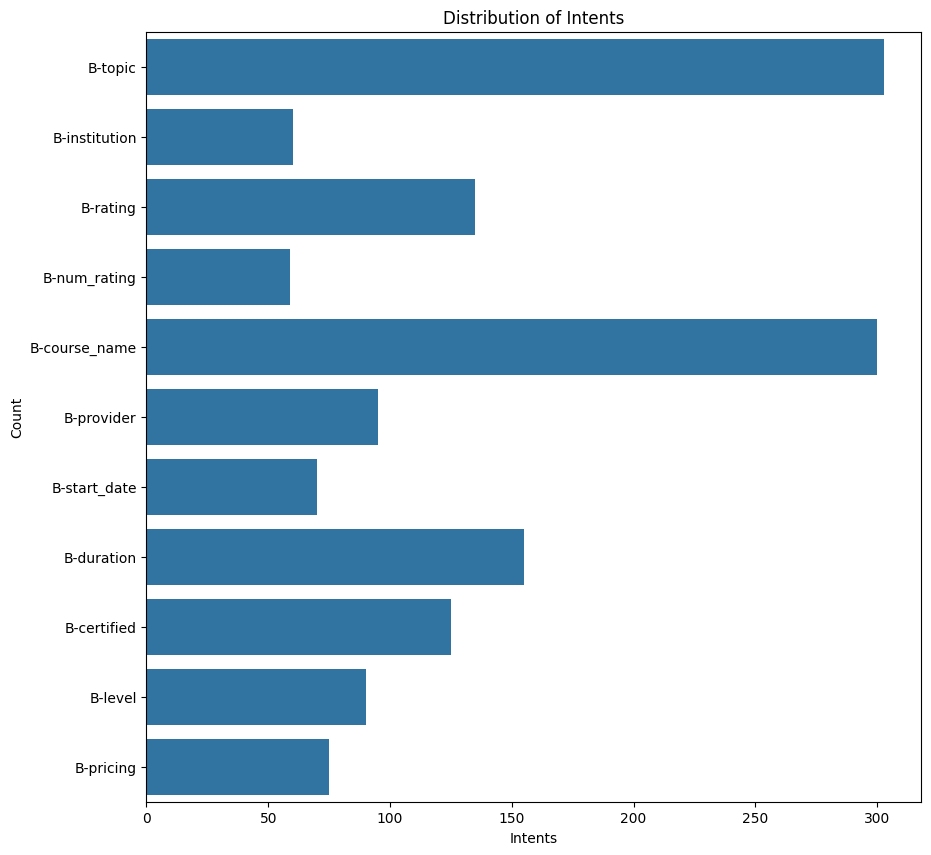

In [ ]:
flattened_list = [item for item in final_df['ner_tags']]
# merged_list = [item for sublist in flattened_list for item in sublist if item != 'O' and item != 'I-course_name']
merged_list = [item for sublist in flattened_list for item in sublist if item.startswith('B-')]

fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.countplot(merged_list)
ax.set_title('Distribution of Intents')
ax.set_xlabel('Intents')
ax.set_ylabel('Count')

plt.show()

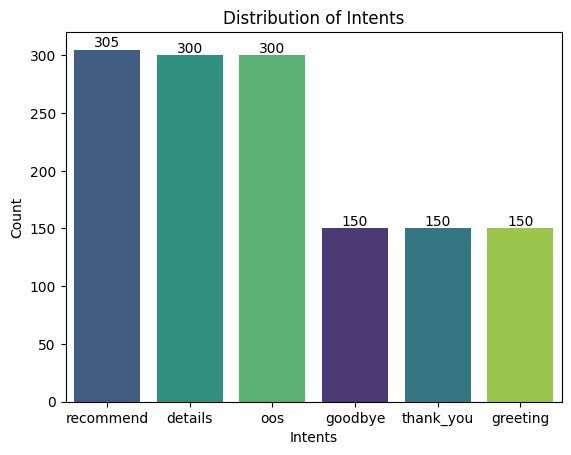

In [ ]:
ax = sns.countplot(x='intent', data=final_df, palette='viridis', hue='intent', order = final_df['intent'].value_counts().index)
ax.set_title('Distribution of Intents')
ax.set_xlabel('Intents')
ax.set_ylabel('Count')

# Add text on the bars
for rect in ax.patches:
    height = round(rect.get_height())
    ax.text(x=rect.get_x() + rect.get_width() / 2, y=height, s=height, ha='center', va='bottom')

plt.show()

### Joint Intent Classifier and Slot filling Model

In [ ]:
def preprocess_texts(text):
    lemmatized_texts = []

    # sentence = re.sub(r'[!.,?]+$', '', text.lower())
    for doc in nlp.pipe(text.lower().split(), disable=["parser", "ner", "textcat"]):
        words = [token.lemma_ for token in doc]
        lemmatized_texts.append(' '.join(words))

    return ' '.join(lemmatized_texts)

In [ ]:
processed_text = final_df['text'].apply(lambda sentence: preprocess_texts(sentence))

In [ ]:
tokenized_texts = final_df['text'].apply(word_tokenize)
max_seq_length = tokenized_texts.apply(len).max()
max_seq_length

39

In [ ]:
print("Min: ", min(final_df['ner_tags'].apply(len)))
print("Max: ", max(final_df['ner_tags'].apply(len)))

Min:  1
Max:  39


In [ ]:
tf.keras.utils.set_random_seed(37)

x_train_text, x_test_text, y_train_intent, y_test_intent, y_train_slots, y_test_slots = train_test_split(
    processed_text.values,
    final_df['intent'],
    final_df['ner_tags'],
    test_size=0.2,
    random_state=42,
    stratify=final_df['intent']
)

vectorize_layer = TextVectorization(standardize=None, output_sequence_length=int(max_seq_length))
vectorize_layer.adapt(x_train_text)

X_train = vectorize_layer(x_train_text).numpy()
X_test = vectorize_layer(x_test_text).numpy()

intent_label_encoder = LabelEncoder()
intent_label_encoder.fit(y_train_intent)

y_train_intent = intent_label_encoder.transform(y_train_intent)
y_test_intent = intent_label_encoder.transform(y_test_intent)

slot_label_encoder = LabelEncoder()
all_slots_train = [tag for tags in y_train_slots for tag in tags]
slot_label_encoder.fit(all_slots_train)

y_train_slots = [slot_label_encoder.transform(tags) for tags in y_train_slots]
y_test_slots = [slot_label_encoder.transform(tags) for tags in y_test_slots]

# Padding slot labels
y_train_slots = tf.keras.utils.pad_sequences(y_train_slots,
    maxlen=max_seq_length, padding='post', value=slot_label_encoder.transform(['O'])[0]
)
y_test_slots = tf.keras.utils.pad_sequences(y_test_slots,
    maxlen=max_seq_length, padding='post', value=slot_label_encoder.transform(['O'])[0]
)

vocab_size = len(vectorize_layer.get_vocabulary())

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_slot_output_f1score',
    mode='max',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_intent_output_loss',
    mode='min',
    factor=0.1,
    patience=5,
    verbose=1
)

In [ ]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='f1score', average='macro', **kwargs):
        super().__init__(name=name, **kwargs)
        self.average = average
        self.num_classes = num_classes
        self.true_positives = tf.Variable(tf.zeros((num_classes,)), shape=(num_classes,), trainable=False)
        self.false_positives = tf.Variable(tf.zeros((num_classes,)), shape=(num_classes,), trainable=False)
        self.false_negatives = tf.Variable(tf.zeros((num_classes,)), shape=(num_classes,), trainable=False)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)

        for i in range(self.num_classes):
            true_positives = tf.reduce_sum(tf.cast((y_true == i) & (y_pred == i), tf.float32))
            false_positives = tf.reduce_sum(tf.cast((y_true != i) & (y_pred == i), tf.float32))
            false_negatives = tf.reduce_sum(tf.cast((y_true == i) & (y_pred != i), tf.float32))

            self.true_positives.assign(tf.tensor_scatter_nd_add(self.true_positives, [[i]], [true_positives]))
            self.false_positives.assign(tf.tensor_scatter_nd_add(self.false_positives, [[i]], [false_positives]))
            self.false_negatives.assign(tf.tensor_scatter_nd_add(self.false_negatives, [[i]], [false_negatives]))

    def result(self):
        precisions = self.true_positives / (self.true_positives + self.false_positives + K.epsilon())
        recalls = self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + K.epsilon())

        supports = self.true_positives + self.false_negatives

        if self.average == 'macro':
            return tf.reduce_mean(f1_scores)
        elif self.average == 'weighted':
            class_weights = supports / tf.reduce_sum(supports)
            return tf.reduce_sum(class_weights * f1_scores)

    def reset_state(self):
        self.true_positives.assign(tf.zeros_like(self.true_positives))
        self.false_positives.assign(tf.zeros_like(self.false_positives))
        self.false_negatives.assign(tf.zeros_like(self.false_negatives))

In [ ]:
class CustomHyperModel(kt.HyperModel):
    def build(self, hp):
        num_dense_layers = [1, 2, 3]
        num_lstm_layers = [0, 2, 3]
        dense_units = [32, 64, 128, 256, 512]
        lstm_units = [32, 64, 128]
        dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]
        activations = ['relu', 'tanh']
        optimizers = ['adam', 'sgd', 'rmsprop']
        batch_size = hp.Choice("batch_size", [16, 32, 64])

        embedding_dim = hp.Int('embedding_dim', min_value=50, max_value=500, step=50)
        active_func = hp.Choice('activation', activations)
        dropout_rate = hp.Choice('dropout_rate', dropout_rates)
        optimizer = hp.Choice('optimizer', optimizers)

        input_text = Input(shape=(None,), name='input_text')
        current = Embedding(vocab_size + 1, embedding_dim, mask_zero=hp.Boolean("mask_zero"))(input_text)

        bi_lstm_unit = hp.Choice('bi_lstm_units', lstm_units)
        current = Bidirectional(LSTM(bi_lstm_unit, return_sequences=True))(current)

        # if hp.Boolean('dropout'):
        #     lstm = Dropout(dropout_rate)(lstm)
        for layer_i in range(hp.Choice('num_lstm_layers', num_lstm_layers)):
            lstm_unit = hp.Choice(f'lstm_{layer_i}_units', lstm_units)
            current = LSTM(units=lstm_unit, return_sequences=True)(current)
            # if hp.Boolean('dropout'):
            #     lstm = Dropout(dropout_rate)(lstm)

        for layer_i in range(hp.Choice('num_dense_layers', num_dense_layers)):
            dense_unit = hp.Choice(f'dense_{layer_i}_units', dense_units)
            current = Dense(units=dense_unit, activation=active_func)(current)
            if hp.Boolean('dropout'):
                current = Dropout(dropout_rate)(current)

        if hp.Boolean('batch_normalize'):
            current = BatchNormalization()(current)
            current = keras.activations.relu(current)

        intent_dropout = Dropout(0.5)(current)
        intent_output = Dense(len(intent_label_encoder.classes_), activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.5), name='intent_output')(intent_dropout[:, -1, :])

        if hp.Boolean('slot_dense'):
            current = TimeDistributed(Dense(hp.Choice('slot_dense_units', dense_units),kernel_regularizer=keras.regularizers.l2(0.01),
                                            activation=hp.Choice('slot_activation', activations)), name='slot_dense')(current)
        # if hp.Boolean('slot_dropout'):
        #     slot_dense = Dropout(dropout_rate)(slot_dense)
        slot_output = TimeDistributed(Dense(len(slot_label_encoder.classes_), activation='softmax'), name='slot_output')(current)

        model = Model(inputs=input_text, outputs=[intent_output, slot_output])

        if optimizer == "sgd":
            optimizer = tf.keras.optimizers.SGD(0.01)
        if optimizer == "rmsprop":
            optimizer = tf.keras.optimizers.RMSprop(0.01)
        else:
            optimizer = tf.keras.optimizers.Adam(0.01)

        model.compile(optimizer=optimizer,
                    loss={'intent_output': 'sparse_categorical_crossentropy', 'slot_output': 'sparse_categorical_crossentropy'},
                    metrics={'intent_output':[keras.metrics.SparseCategoricalAccuracy(name='accuracy')],
                             'slot_output': [F1Score(num_classes=len(slot_label_encoder.classes_))]})

        return model

        def fit(self, hp, model, *args, **kwargs):
            return model.fit(*args,
                            batch_size=hp.get('batch_size'),
                            **kwargs)

In [ ]:
tuner = kt.BayesianOptimization(
    CustomHyperModel(),
    objective=[kt.Objective("val_intent_output_accuracy", direction="max"), kt.Objective("val_slot_output_f1score", direction="max")],
    # max_trials=15,
    seed=37,
    directory=f'{base_dir}/tuned_model2',
    project_name="joint_intents_slot",
    overwrite=True,
)

tuner.search_space_summary()

Search space summary
Default search space size: 13
batch_size (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
embedding_dim (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 500, 'step': 50, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3, 0.4, 0.5], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd', 'rmsprop'], 'ordered': False}
mask_zero (Boolean)
{'default': False, 'conditions': []}
bi_lstm_units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
num_lstm_layers (Choice)
{'default': 0, 'conditions': [], 'values': [0, 2, 3], 'ordered': True}
num_dense_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
dense_0_units (Choice)
{'default': 32, 'conditions':

In [ ]:
tuner.search(x=X_train, y={'intent_output': y_train_intent, 'slot_output': y_train_slots},
             epochs=100,  validation_split=0.2, callbacks=[reduce_lr, early_stopping])

Trial 10 Complete [00h 01m 57s]
multi_objective: -1.0788642168045044

Best multi_objective So Far: -1.897665798664093
Total elapsed time: 00h 42m 54s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'batch_size': 64,
 'embedding_dim': 300,
 'activation': 'relu',
 'dropout_rate': 0.3,
 'optimizer': 'adam',
 'mask_zero': True,
 'bi_lstm_units': 128,
 'num_lstm_layers': 2,
 'num_dense_layers': 1,
 'dense_0_units': 512,
 'dropout': True,
 'batch_normalize': True,
 'slot_dense': False,
 'lstm_0_units': 64,
 'lstm_1_units': 64,
 'dense_1_units': 128,
 'slot_dense_units': 256,
 'slot_activation': 'tanh'}

In [ ]:
tuner.results_summary(3)

Results summary
Results in /content/drive/MyDrive/project/tuned_model2/joint_intents_slot
Showing 3 best trials
MultiObjective(name="multi_objective", direction="min"): [Objective(name="val_intent_output_accuracy", direction="max"), Objective(name="val_slot_output_f1score", direction="max")]

Trial 05 summary
Hyperparameters:
batch_size: 64
embedding_dim: 300
activation: relu
dropout_rate: 0.3
optimizer: adam
mask_zero: True
bi_lstm_units: 128
num_lstm_layers: 2
num_dense_layers: 1
dense_0_units: 512
dropout: True
batch_normalize: True
slot_dense: False
lstm_0_units: 64
lstm_1_units: 64
dense_1_units: 128
slot_dense_units: 256
slot_activation: tanh
Score: -1.897665798664093

Trial 00 summary
Hyperparameters:
batch_size: 64
embedding_dim: 350
activation: relu
dropout_rate: 0.3
optimizer: sgd
mask_zero: True
bi_lstm_units: 32
num_lstm_layers: 2
num_dense_layers: 1
dense_0_units: 512
dropout: False
batch_normalize: True
slot_dense: False
lstm_0_units: 32
lstm_1_units: 32
Score: -1.8740063

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_text (InputLayer)     [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 300)            490200    ['input_text[0][0]']          
                                                                                                  
 bidirectional (Bidirection  (None, None, 256)            439296    ['embedding[0][0]']           
 al)                                                                                              
                                                                                                  
 lstm_1 (LSTM)               (None, None, 64)             82176     ['bidirectional[0][0]']   

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x=X_train, y={'intent_output': y_train_intent, 'slot_output': y_train_slots}, batch_size=64,
             epochs=100,  validation_split=0.2, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
14/14 [==============================] - 53s 1s/step - loss: 3.5008 - intent_output_loss: 1.1383 - slot_output_loss: 0.7261 - intent_output_accuracy: 0.5686 - slot_output_f1score: 0.0518 - val_loss: 2.1761 - val_intent_output_loss: 1.2770 - val_slot_output_loss: 0.3532 - val_intent_output_accuracy: 0.5576 - val_slot_output_f1score: 0.0459 - lr: 0.0100
Epoch 2/100
14/14 [==============================] - 8s 556ms/step - loss: 1.3012 - intent_output_loss: 0.4960 - slot_output_loss: 0.3258 - intent_output_accuracy: 0.8166 - slot_output_f1score: 0.0699 - val_loss: 1.7331 - val_intent_output_loss: 1.1102 - val_slot_output_loss: 0.3260 - val_intent_output_accuracy: 0.7880 - val_slot_output_f1score: 0.0459 - lr: 0.0100
Epoch 3/100
14/14 [==============================] - 11s 758ms/step - loss: 0.8250 - intent_output_loss: 0.2980 - slot_output_loss: 0.2680 - intent_output_accuracy: 0.9181 - slot_output_f1score: 0.0815 - val_loss: 1.4911 - val_intent_output_loss: 1.0106 - val_slot_o

### Evaluation

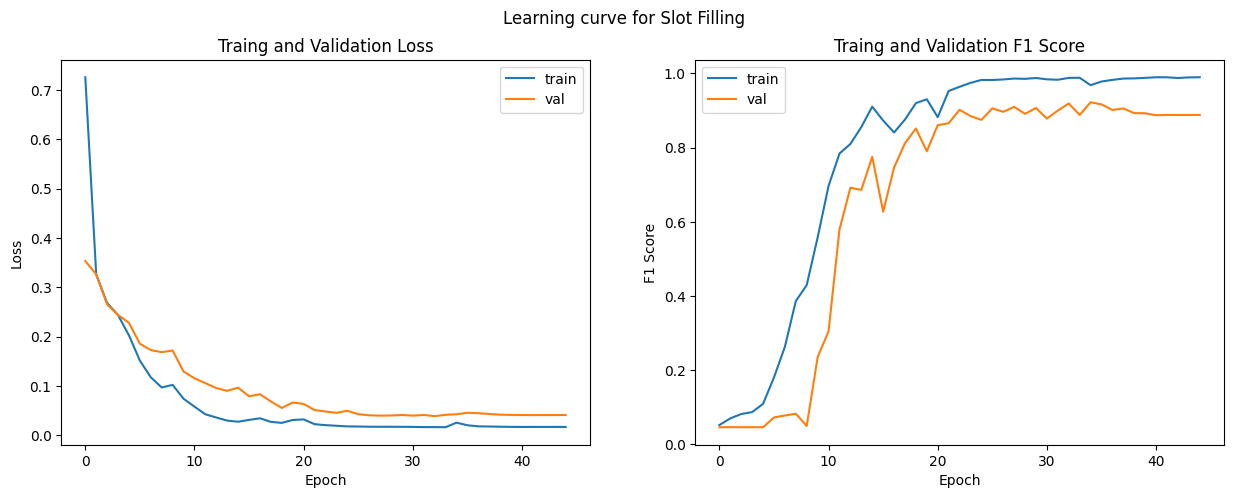

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle('Learning curve for Slot Filling')

axes[0].set_title('Traing and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].plot(history.history['slot_output_loss'], label='train')
axes[0].plot(history.history['val_slot_output_loss'], label='val')
axes[0].legend()

axes[1].set_title('Traing and Validation F1 Score')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score')
axes[1].plot(history.history['slot_output_f1score'], label='train')
axes[1].plot(history.history['val_slot_output_f1score'], label='val')
axes[1].legend()

plt.show()

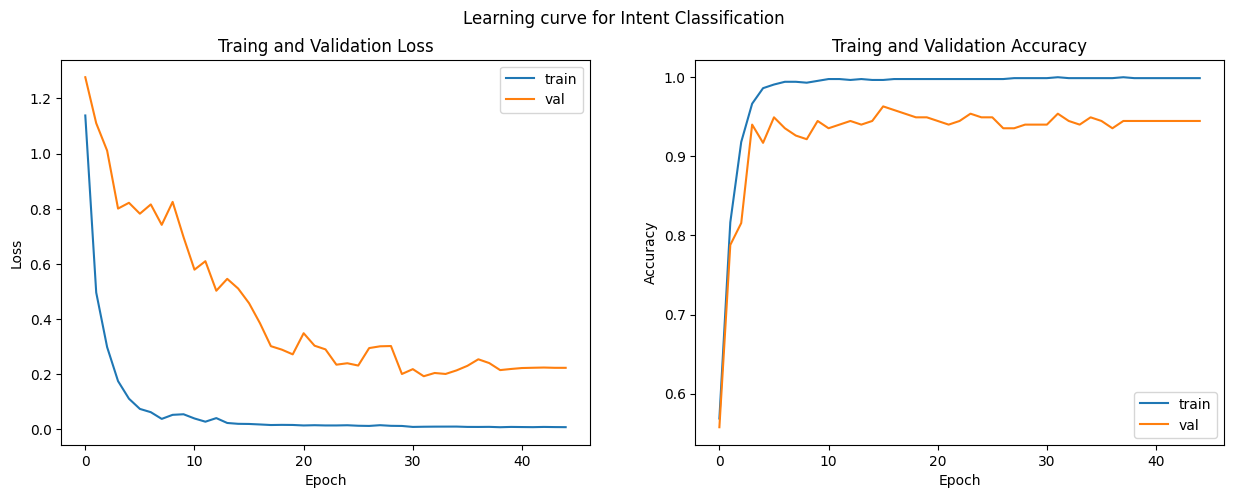

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle('Learning curve for Intent Classification')

axes[0].set_title('Traing and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].plot(history.history['intent_output_loss'], label='train')
axes[0].plot(history.history['val_intent_output_loss'], label='val')
axes[0].legend()

axes[1].set_title('Traing and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].plot(history.history['intent_output_accuracy'], label='train')
axes[1].plot(history.history['val_intent_output_accuracy'], label='val')
axes[1].legend()

plt.show()

In [ ]:
model.evaluate(X_test, {'intent_output': y_test_intent, 'slot_output': y_test_slots}, batch_size=32)

9/9 [==============================] - 2s 214ms/step - loss: 0.4836 - intent_output_loss: 0.3916 - slot_output_loss: 0.0591 - intent_output_accuracy: 0.9114 - slot_output_f1score: 0.8745


[0.48358801007270813,
 0.39160865545272827,
 0.05906150862574577,
 0.9114391207695007,
 0.8745465874671936]

In [ ]:
from sklearn.metrics import classification_report

y_intent_pred, y_slot_pred = model.predict(X_test)

y_intent_pred_classes = np.argmax(y_intent_pred, axis=-1)
y_slot_pred_classes = np.argmax(y_slot_pred, axis=-1)

9/9 [==============================] - 1s 152ms/step


In [ ]:
intent_report = classification_report(y_test_intent, y_intent_pred_classes, target_names=intent_label_encoder.classes_)
print("Intent Classification Report:\n", intent_report)

Intent Classification Report:
               precision    recall  f1-score   support

     details       1.00      1.00      1.00        60
     goodbye       0.75      0.80      0.77        30
    greeting       0.78      0.83      0.81        30
         oos       0.94      0.85      0.89        60
   recommend       1.00      1.00      1.00        61
   thank_you       0.81      0.87      0.84        30

    accuracy                           0.91       271
   macro avg       0.88      0.89      0.89       271
weighted avg       0.92      0.91      0.91       271



In [ ]:
slot_report = classification_report(y_test_slots.flatten(), y_slot_pred_classes.flatten(), labels=range(len(slot_label_encoder.classes_)),
                                    zero_division=1.0, target_names=slot_label_encoder.classes_)
print("Slot Classification Report:\n", slot_report)

Slot Classification Report:
                precision    recall  f1-score   support

  B-certified       1.00      1.00      1.00        20
B-course_name       0.95      0.87      0.90        60
   B-duration       1.00      0.93      0.96        28
B-institution       0.90      0.69      0.78        13
      B-level       1.00      1.00      1.00        15
 B-num_rating       1.00      0.91      0.95        11
    B-pricing       0.93      0.93      0.93        15
   B-provider       0.65      0.85      0.73        13
     B-rating       0.96      1.00      0.98        27
 B-start_date       1.00      1.00      1.00        15
      B-topic       0.91      0.98      0.94        60
I-course_name       0.98      0.93      0.96       336
   I-duration       0.98      0.95      0.96        56
I-institution       1.00      0.27      0.42        30
 I-num_rating       0.86      1.00      0.92        12
    I-pricing       1.00      0.82      0.90        11
   I-provider       0.10      0.33 

In [ ]:
model_path = os.path.join(base_dir, f"models/Joint_intent_slot{session_time}")
model.save(model_path)

with open(os.path.join(model_path, "history.pkl"), 'wb') as file:
    pickle.dump(history.history, file)

In [ ]:
# model = tf.keras.models.load_model(f"{base_dir}/models/Joint_intent_slot1720377739")

# with open(f"{base_dir}/models/Joint_intent_slot1720377739/history.pkl", 'rb') as file:
#     history = pickle.load(file)

### Course Retrieval

In [ ]:
def predict_intent_and_slots(sentence, label_encoder, slot_encoder):
    sentence_seq = vectorize_layer([preprocess_texts(sentence)]).numpy()

    # Make predictions
    intent_pred, slot_pred = model.predict(sentence_seq)

    # Decode intent
    intent_idx = np.argmax(intent_pred, axis=1)
    intent_dict = {"intent": label_encoder.inverse_transform(intent_idx)[0]}

    # # Decode slot labels
    slot_idx = np.argmax(slot_pred[0], axis=1)
    slot_label = slot_encoder.inverse_transform(slot_idx)
    input_tokens = [token.text for token in nlp(sentence)]
    # input_tokens = word_tokenize(sentence) #sentence.split()
    trimmed_slots = slot_label[:len(input_tokens)]
    print(slot_label)
    indices = [i for i in range(len(trimmed_slots)) if trimmed_slots[i] != 'O']

    slots_dict = {}
    for i in indices:
        slot = trimmed_slots[i].split('-')[1]
        slots_dict[slot] = slots_dict[slot] + f" {input_tokens[i]}" if slot in slots_dict else input_tokens[i]
        # slots_dict[slot] = slots_dict[slot] + f" {sentence.split()[i]}" if slot in slots_dict else sentence.split()[i]

    return intent_dict, slots_dict

In [ ]:
stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    words = word_tokenize(text)
    filtered_words = [stemmer.stem(word) for word in words if word not in stop_words]
    return " ".join(filtered_words)


def filter_by_rating(df, rating_value):
    rating_value = rating_value.lower()
    # Check if the rating_value is a simple number
    number_pattern = re.compile(r'^\d+(\.\d+)?$')
    if number_pattern.match(rating_value):
        rating_threshold = float(rating_value)
        filtered_df = df[df['course_avg_rating'] >= rating_threshold]
    else:
        # Check for comparison keywords and extract the numerical value
        match = re.search(r'(\d+(\.\d+)?)(?=\s*$)', rating_value)
        if match:
            rating_threshold = float(match.group(1))
            if 'above' in rating_value or 'greater' in rating_value or 'more' in rating_value:
                filtered_df = df[df['course_avg_rating'] > rating_threshold]
            elif 'below' in rating_value or 'less' in rating_value:
                filtered_df = df[df['course_avg_rating'] < rating_threshold]
            else:
                # Default to equality if no comparison keyword is found
                filtered_df = df[df['course_avg_rating'] >= rating_threshold]
        else:
            raise ValueError("Invalid rating value format")

    return filtered_df

In [ ]:
def get_matching_course(slots, course_df):
    # Mapping from slots to DataFrame columns
    slot_to_column = {
        "rating": "course_avg_rating",
        "topic": "course_subject",
        "certified": "course_certificate",
        "institution": "course_institution",
        "level": "course_level",
        "link": "course_link",
        "course_name": "course_name",
        "num_rating": "course_num_rating",
        "provider": "course_provider",
        "duration": "duration",
        "pricing": "pricing",
        "start_date": "start_date",
        "teacher": "teacher"
    }

    df_copy = df.copy()

    vectorizer = TfidfVectorizer()

    ordered_slots = ["certified", "rating", "num_rating", "course_name", "institution", "provider", "level", "duration", "start_date", "pricing", "topic"]
    query_slots = {key: slots[key] for key in ordered_slots  if key in slots}

    for slot, value in query_slots.items():
        if slot in slot_to_column:
            column = slot_to_column[slot]

            match slot:
                case "certified":
                    df_copy = df_copy[df_copy[column] == True]
                case "rating" | "num_rating":
                    df_copy = filter_by_rating(df_copy, value)
                case "topic" | "institution" | "provider" | "teacher" | "level" |  "duration" | "start_date" | "pricing":
                    df_copy = df_copy[df_copy[column].notna()]
                    sentence_tokens = preprocess_text(value)
                    course_vector = vectorizer.fit_transform(df_copy[column].apply(preprocess_text))
                    query_vector = vectorizer.transform([sentence_tokens])
                    df_copy = recommend_courses_cosine(query_vector, course_vector, df_copy, top_n=50)
                case _:
                    raise ValueError("Invalid slot type")

    return df_copy[:6].reset_index(drop=True)

Sample usage

In [ ]:
user_query = "I want an advanced course on python OOP and data structures and rating of above 4.0?"
# user_query = "what ieee focs: foundations of computer science courses with a rating of greater than 4.0 and a start date of june 1 can you recommend?"
# user_query = random.choice(x_test_text)
intent, slots = predict_intent_and_slots(user_query, intent_label_encoder, slot_label_encoder)

print(f"sentence: {user_query}")
print(f"Intent: {intent}")
print(f"Slots: {slots}")

1/1 [==============================] - 0s 89ms/step
['O' 'O' 'O' 'B-level' 'O' 'O' 'B-topic' 'I-topic' 'I-topic' 'I-topic'
 'I-topic' 'O' 'O' 'O' 'B-rating' 'I-rating' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']
sentence: I want an advanced course on python OOP and data structures and rating of above 4.0?
Intent: {'intent': 'recommend'}
Slots: {'level': 'advanced', 'topic': 'python OOP and data structures', 'rating': 'above 4.0'}


In [ ]:
matching_courses = get_matching_course(slots, df)
matching_courses[['course_name', 'course_avg_rating', 'course_level', 'course_subject', 'cosine_sim']]

2 dict_items([('rating', 'above 4.0'), ('level', 'advanced'), ('topic', 'python OOP and data structures')])


,course_name,course_avg_rating,course_level,course_subject,cosine_sim
0,"Dynamic Programming, Greedy Algorithms",5.00000,advanced,Algorithms and Data Structures,0.789184
1,Trees and Graphs: Basics,5.00000,advanced,Algorithms and Data Structures,0.789184
2,Design of Computer Programs,4.14286,advanced,Algorithms and Data Structures,0.789184
3,Paradigms of Computer Programming – Abstractio...,4.40000,advanced,Algorithms and Data Structures,0.789184
4,"Computability, Complexity & Algorithms",5.00000,advanced,Algorithms and Data Structures,0.789184
5,Python for Data Science,4.43750,advanced,Data Science,0.426837
6,Practical Data Science on the AWS Cloud,5.00000,advanced,Data Science,0.426837
7,Data Scientist,4.90909,advanced,Data Science,0.426837
8,Advanced Linear Models for Data Science 2: Sta...,5.00000,advanced,Data Science,0.426837
9,Advanced Linear Models for Data Science 1: Lea...,5.00000,advanced,Data Science,0.426837


* investigate low cosine similarity
* try user queries that are not similar to the sample data
* try creating the embedding with word2vec and other embedding tools

### Response Generation

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    low_cpu_mem_usage=False,
)

# model.to("cuda")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
def prompt_formatter(query, context_df, intent) -> str:
    # context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])
    context = "- " + "\n- ".join(context_df["combined_details"].tolist()) if context_df is not None else None

    base_prompt = """You are an intelligent course recommendation assistant. Your goal is to provide users with clear, helpful, and engaging recommendations based on the retrieved courses and their intent. You should handle the following intents:
1. recommend: You should introduce the recommendations, list them, and provide a brief description for each course.
2. details: Provide specific details about the course.
3. oos: Politely inform the user that the question is outside your specialization.
4. greeting: Respond politely to greetings.
5. goodbye: Respond politely to farewells.
6. thank_you: Respond politely to thank-you messages.
Maintain a friendly and professional tone throughout your responses.
\nNow use the following intent to respond to the user query:
{intent}
\nNow use the following context items to respond to the user query:
{context}
\nRelevant recommendations: <extract relevant recommendations from the context here>
User query: {query}
Answer:"""
    base_prompt = base_prompt.format(intent=intent, context=context,query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
         "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                           tokenize=False,
                                           add_generation_prompt=True)

    return prompt


print(f"Query: {user_query}")


# Format the prompt
prompt = prompt_formatter(query=user_query, context_df=matching_courses, intent="recommend")
print(prompt)

Query: I want advanced course on python covering OOP and data structures with an average rating above 4.0
<|user|>
You are an intelligent course recommendation assistant. Your goal is to provide users with clear, helpful, and engaging recommendations based on the retrieved courses and their intent. You should handle the following intents:
1. recommend: You should introduce the recommendations, list them, and provide a brief description for each course.
2. details: Provide specific details about the course.
3. oos: Politely inform the user that the question is outside your specialization.
4. greeting: Respond politely to greetings.
5. goodbye: Respond politely to farewells.
6. thank_you: Respond politely to thank-you messages.
Maintain a friendly and professional tone throughout your responses.

Now use the following intent to respond to the user query:
recommend

Now use the following context items to respond to the user query:
- Dynamic Programming, Greedy Algorithms: This Free Online

In [ ]:
user_tag = re.escape("<|user|>")
assistant_tag = re.escape("<|assistant|>")
end_tag = re.escape("<|end|>")

def ask(query: str, temperature: float=0.7, max_new_tokens:int=256, format_answer_text=True, return_answer_only=True):
    intent, slots = predict_intent_and_slots(query, intent_label_encoder, slot_label_encoder)
    matching_courses = get_matching_course(slots, df)

    prompt = prompt_formatter(query=query, context_df=matching_courses, intent=intent)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt")

    # Generate an output of tokens
    outputs = model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 streamer=TextStreamer(tokenizer, skip_prompt=True),
                                 max_new_tokens=max_new_tokens)

    # Decode the tokens into text
    output_text = tokenizer.decode(outputs[0])

    ## Format the answer
    if format_answer_text:
        output_text = re.sub(f"{user_tag}.*?{end_tag}", '', output_text, flags=re.DOTALL)\
                        .replace("<|user|>", "").replace("<|end|>", "").replace("<|assistant|>", "").strip()

    # Only return the answer without context items
    if return_answer_only:
        return output_text

    return output_text, matching_courses

### Sample Usage of the Whole Pipeline

In [ ]:
# user_query = random.choice(x_test_text)
user_query = "I want an advanced course on python OOP and data structures and rating of above 4.0?"
ask(query=user_query, intent="recommend", context_df=matching_courses, temperature=0.6)

Query: I want advanced course on python covering OOP and data structures with an average rating above 4.0
I recommend the following courses based on your interest in advanced Python covering Object-Oriented Programming (OOP) and data structures with an average rating above 4.0:

1. Paradigms of Computer Programming – Fundamentals:
  - Teacher: Peter Van Roy
  - Duration: 6 weeks, 4-6 hours a week
  - Description: This course introduces major programming concepts, techniques, and paradigms in a unified framework, including functional, object-oriented, and declarative dataflow programming. It covers functional programming, its techniques, and data structures, as well as object-oriented programming and data abstraction.

2. Data Analysis: Statistical Modeling and Computation in Applications:
  - Teacher: Stefanie Jegelka, Caroline Uhler, Karene Chu
  - Duration: 35 minutes
  - Description: This course combines statistical and computational tools with domain knowledge to analyze real data 

"Based on your interest in an advanced course on Python covering Object-Oriented Programming (OOP) and data structures with an average rating above 4.0, I recommend the following courses:\n\n1. Paradigms of Computer Programming – Fundamentals:\n   - Rating: 5.0\n   - Duration: 6 weeks, 4-6 hours a week\n   - Description: This course covers functional, object-oriented, and declarative dataflow programming in a unified framework. It provides practical code fragments and a simple semantics to understand the concepts.\n\n2. Data Analysis: Statistical Modeling and Computation in Applications:\n   - Rating: 5.0\n   - Duration: 35 minutes\n   - Description: This course combines foundational and practical skills with domain knowledge to analyze real data using statistical and computational tools. It covers hypothesis testing, regression, and gradient descent methods.\n\n3. Websites and Web Applications:\n   - Rating: 5.0\n   - Duration: 1 hour 30 minutes\n   - Description: This course offers h